In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os, time
from glob import glob
import sys
import tarfile
import scipy.io as sio


from IPython.display import display, Image
from scipy import ndimage, misc

from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import tensorflow as tf
import tensorlayer as tl
from tensorlayer.layers import *



In [2]:
def u_net_bn(x, is_train=False, reuse=False, batch_size=None, pad='SAME', n_out=1):
    """image to image translation via conditional adversarial learning"""
    nx = int(x._shape[1])
    ny = int(x._shape[2])
    nz = int(x._shape[3])
    print(" * Input: size of image: %d %d %d" % (nx, ny, nz))

    w_init = tf.truncated_normal_initializer(stddev=0.01)
    b_init = tf.constant_initializer(value=0.0)
    gamma_init=tf.random_normal_initializer(1., 0.02)
    with tf.variable_scope("u_net", reuse=reuse):
        tl.layers.set_name_reuse(reuse)
        inputs = InputLayer(x, name='inputs')

        conv1 = Conv2d(inputs, 64, (4, 4), (2, 2), act=None, padding=pad, W_init=w_init, b_init=b_init, name='conv1')
        conv2 = Conv2d(conv1, 128, (4, 4), (2, 2), act=None, padding=pad, W_init=w_init, b_init=b_init, name='conv2')
        conv2 = BatchNormLayer(conv2, act=lambda x: tl.act.lrelu(x, 0.2), is_train=is_train, gamma_init=gamma_init, name='bn2')

        conv3 = Conv2d(conv2, 256, (4, 4), (2, 2), act=None, padding=pad, W_init=w_init, b_init=b_init, name='conv3')
        conv3 = BatchNormLayer(conv3, act=lambda x: tl.act.lrelu(x, 0.2), is_train=is_train, gamma_init=gamma_init, name='bn3')

        conv4 = Conv2d(conv3, 512, (4, 4), (2, 2), act=None, padding=pad, W_init=w_init, b_init=b_init, name='conv4')
        conv4 = BatchNormLayer(conv4, act=lambda x: tl.act.lrelu(x, 0.2), is_train=is_train, gamma_init=gamma_init, name='bn4')

        conv5 = Conv2d(conv4, 512, (4, 4), (2, 2), act=None, padding=pad, W_init=w_init, b_init=b_init, name='conv5')
        conv5 = BatchNormLayer(conv5, act=lambda x: tl.act.lrelu(x, 0.2), is_train=is_train, gamma_init=gamma_init, name='bn5')

        conv6 = Conv2d(conv5, 512, (4, 4), (2, 2), act=None, padding=pad, W_init=w_init, b_init=b_init, name='conv6')
        conv6 = BatchNormLayer(conv6, act=lambda x: tl.act.lrelu(x, 0.2), is_train=is_train, gamma_init=gamma_init, name='bn6')

        conv7 = Conv2d(conv6, 512, (4, 4), (2, 2), act=None, padding=pad, W_init=w_init, b_init=b_init, name='conv7')
        conv7 = BatchNormLayer(conv7, act=lambda x: tl.act.lrelu(x, 0.2), is_train=is_train, gamma_init=gamma_init, name='bn7')

        conv8 = Conv2d(conv7, 512, (4, 4), (2, 2), act=lambda x: tl.act.lrelu(x, 0.2), padding=pad, W_init=w_init, b_init=b_init, name='conv8')
        print(" * After conv: %s" % conv8.outputs)
        # exit()
        # print(nx/8)
        up7 = DeConv2d(conv8, 512, (4, 4), out_size=(2, 2), strides=(2, 2),
                                    padding=pad, act=None, batch_size=batch_size, W_init=w_init, b_init=b_init, name='deconv7')
        up7 = BatchNormLayer(up7, act=tf.nn.relu, is_train=is_train, gamma_init=gamma_init, name='dbn7')

        # print(up6.outputs)
        up6 = ConcatLayer([up7, conv7], concat_dim=3, name='concat6')
        up6 = DeConv2d(up6, 1024, (4, 4), out_size=(4, 4), strides=(2, 2),
                                                   padding=pad, act=None, batch_size=batch_size, W_init=w_init, b_init=b_init, name='deconv6')
        up6 = BatchNormLayer(up6, act=tf.nn.relu, is_train=is_train, gamma_init=gamma_init, name='dbn6')
        # print(up6.outputs)
        # exit()

        up5 = ConcatLayer([up6, conv6], concat_dim=3, name='concat5')
        up5 = DeConv2d(up5, 1024, (4, 4), out_size=(8, 8), strides=(2, 2),
                                    padding=pad, act=None, batch_size=batch_size, W_init=w_init, b_init=b_init, name='deconv5')
        up5 = BatchNormLayer(up5, act=tf.nn.relu, is_train=is_train, gamma_init=gamma_init, name='dbn5')
        # print(up5.outputs)
        # exit()

        up4 = ConcatLayer([up5, conv5] ,concat_dim=3, name='concat4')
        up4 = DeConv2d(up4, 1024, (4, 4), out_size=(15, 15), strides=(2, 2),
                                    padding=pad, act=None, batch_size=batch_size, W_init=w_init, b_init=b_init, name='deconv4')
        up4 = BatchNormLayer(up4, act=tf.nn.relu, is_train=is_train, gamma_init=gamma_init, name='dbn4')

        up3 = ConcatLayer([up4, conv4] ,concat_dim=3, name='concat3')
        up3 = DeConv2d(up3, 256, (4, 4), out_size=(30, 30), strides=(2, 2),
                                    padding=pad, act=None, batch_size=batch_size, W_init=w_init, b_init=b_init, name='deconv3')
        up3 = BatchNormLayer(up3, act=tf.nn.relu, is_train=is_train, gamma_init=gamma_init, name='dbn3')

        up2 = ConcatLayer([up3, conv3] ,concat_dim=3, name='concat2')
        up2 = DeConv2d(up2, 128, (4, 4), out_size=(60, 60), strides=(2, 2),
                       padding=pad, act=None, batch_size=batch_size, W_init=w_init, b_init=b_init, name='deconv2')
        up2 = BatchNormLayer(up2, act=tf.nn.relu, is_train=is_train, gamma_init=gamma_init, name='dbn2')

        up1 = ConcatLayer([up2, conv2] ,concat_dim=3, name='concat1')
        up1 = DeConv2d(up1, 64, (4, 4), out_size=(120, 120), strides=(2, 2),
                                    padding=pad, act=None, batch_size=batch_size, W_init=w_init, b_init=b_init, name='deconv1')
        up1 = BatchNormLayer(up1, act=tf.nn.relu, is_train=is_train, gamma_init=gamma_init, name='dbn1')

        up0 = ConcatLayer([up1, conv1] ,concat_dim=3, name='concat0')
        up0 = DeConv2d(up0, 64, (4, 4), out_size=(240, 240), strides=(2, 2),
                                    padding=pad, act=None, batch_size=batch_size, W_init=w_init, b_init=b_init, name='deconv0')
        up0 = BatchNormLayer(up0, act=tf.nn.relu, is_train=is_train, gamma_init=gamma_init, name='dbn0')
        # print(up0.outputs)
        # exit()

        out = Conv2d(up0, n_out, (1, 1), act=tf.nn.sigmoid, name='out')

        print(" * Output: %s" % out.outputs)
        # exit()

    return out


In [3]:
#augment data with horizontal and vertical flips, rotation, shift, shear, zoom, brightness, and elastic distortion
#image = mristack :flair, t1, t1c, t2, ground (shape = (240, 240 ))
def distort_imgs(image):
    x1, x2, x3, x4, y = image
    x1, x2, x3, x4, y = tl.prepro.flip_axis_multi([x1, x2, x3, x4, y], axis=0, is_random=True)
    x1, x2, x3, x4, y = tl.prepro.flip_axis_multi([x1, x2, x3, x4, y], axis=1, is_random=True)
    x1, x2, x3, x4, y = tl.prepro.elastic_transform_multi([x1, x2, x3, x4, y],
                            alpha=720, sigma=24, is_random=True)
    x1, x2, x3, x4, y = tl.prepro.rotation_multi([x1, x2, x3, x4, y], rg=20,
                            is_random=True, fill_mode='constant') # nearest, constant
    x1, x2, x3, x4, y = tl.prepro.shift_multi([x1, x2, x3, x4, y], wrg=0.10,
                            hrg=0.10, is_random=True, fill_mode='constant')
    x1, x2, x3, x4, y = tl.prepro.shear_multi([x1, x2, x3, x4, y], 0.05,
                            is_random=True, fill_mode='constant')
    x1, x2, x3, x4, y = tl.prepro.zoom_multi([x1, x2, x3, x4, y],
                            zoom_range=[0.9, 1.1], is_random=True,
                            fill_mode='constant')
   # x1, x2, x3, x4, y = tl.prepro.brightness_multi([x1, x2, x3, x4, y], gamma=0.2, gain=1, is_random=True)
    return x1, x2, x3, x4, y

In [4]:
%matplotlib inline
def showDataImages(dataset,n): # shows size of the sample    
    
   # indices=np.random.choice(dataset.shape[0], n)
    fig=plt.figure()   
    for i in range(n):
        a=fig.add_subplot(1,n,i+1)
        d = dataset[:, :, i]
        
        plt.imshow(d)
        
        # a.set_title(chr(labels[indices[i]]+ord('A')))
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
        
    plt.show()

In [5]:

def run_u_net(task='all'):
    ## Create folder to save trained model and result images
    save_dir = "checkpoint"
    tl.files.exists_or_mkdir(save_dir)
  #  tl.files.exists_or_mkdir("samples/{}".format(task))

    ###======================== LOAD DATA ===================================###
    ## by importing this, you can load a training set and a validation set.
    # you will get X_train_input, X_train_target, X_dev_input and X_dev_target
    # there are 4 labels in targets:
    # Label 0: background
    # Label 1: necrotic 
    # Label 2: edema
    # label 3: non-enhancing tumor
    # Label 4: enhancing tumor
    
    import get_mixed_datasets as dataset
    X_train = dataset.X_train    
    y_train = dataset.y_train[:,:,:,np.newaxis]   
    X_test = dataset.X_test   
    y_test = dataset.y_test[:,:,:,np.newaxis]
        
    if task == 'all':
        y_train = (y_train > 0).astype(int)
        y_test = (y_test > 0).astype(int)
    elif task == 'core':
        y_train = np.logical_and(y_train > 0, y_train != 2).astype(int)       
        y_test = np.logical_and(y_test > 0, y_test != 2).astype(int) 
    
    elif task == 'necrotic':
        y_train = (y_train == 1).astype(int)
        y_test = (y_test == 1).astype(int)
    elif task == 'edema':
        y_train = (y_train == 2).astype(int)
        y_test = (y_test == 2).astype(int)
    elif task == 'enhance':
        y_train = (y_train == 4).astype(int)
        y_test = (y_test == 4).astype(int)
 
        
    else:
        exit("Unknown task %s" % task)
###======================== HYPER-PARAMETERS ============================###
    batch_size = 15#10
    lr = 0.0001 
  #  lr_decay = 0.5
    # decay_every = 100
    beta1 = 0.9
    n_epoch = 25#100
    print_freq_step = 100
    keep = 0.8
###======================== SHOW DATA ===================================###
    # show one slice
    X = np.asarray(X_train[80])
    y = np.asarray(y_train[80])
    print(X.shape, X.min(), X.max()) # (240, 240, 4) -0.338576 11.022792
    print(y.shape, y.min(), y.max()) # (240, 240, 1) 0 1

    showDataImages(X,4)
    showDataImages(y,1)
    nw, nh, nz = X.shape
   # vis_imgs(X, y, 'samples/{}/_train_im.png'.format(task))
    # show data augumentation results
    for i in range(10):
        x_flair, x_t1, x_t1ce, x_t2, label = distort_imgs([X[:,:,0,np.newaxis], X[:,:,1,np.newaxis],
                X[:,:,2,np.newaxis], X[:,:,3,np.newaxis], y])#[:,:,np.newaxis]])
        # print(x_flair.shape, x_t1.shape, x_t1ce.shape, x_t2.shape, label.shape) # (240, 240, 1) (240, 240, 1) (240, 240, 1) (240, 240, 1) (240, 240, 1)
        X_dis = np.concatenate((x_flair, x_t1, x_t1ce, x_t2), axis=2)
        # print(X_dis.shape, X_dis.min(), X_dis.max()) # (240, 240, 4) -0.380588233471 2.62376139209
      #  vis_imgs(X_dis, label, 'samples/{}/_train_im_aug{}.png'.format(task, i))

    with tf.device('/cpu:0'):
        sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
        with tf.device('/gpu:0'): #<- remove it if you train on CPU or other GPU
            ###======================== DEFIINE MODEL =======================###
            ## nz is 4 as we input all Flair, T1, T1c and T2.
            t_image = tf.placeholder('float32', [batch_size, nw, nh, nz], name='input_image')
            ## labels are either 0 or 1
            t_seg = tf.placeholder('float32', [batch_size, nw, nh, 1], name='target_segment')
            
            ## train inference
            net = u_net_bn(t_image, is_train=True, reuse=False, n_out=1)
            ## test inference
            net_test = u_net_bn(t_image, is_train=False, reuse=True, n_out=1)
            ###======================== DEFINE LOSS =========================###
            ## train losses
            out_seg = net.outputs
            dice_loss = 1 - tl.cost.dice_coe(out_seg, t_seg, axis=[0,1,2,3])#, 'jaccard', epsilon=1e-5)
            iou_loss = tl.cost.iou_coe(out_seg, t_seg, axis=[0,1,2,3])
            dice_hard = tl.cost.dice_hard_coe(out_seg, t_seg, axis=[0,1,2,3])
            ce_loss = tl.cost.binary_cross_entropy(out_seg, t_seg)
            loss = 0.5*(dice_loss+ce_loss)
            

            ## test losses
            test_out_seg = net_test.outputs
            test_dice_loss = 1 - tl.cost.dice_coe(test_out_seg, t_seg, axis=[0,1,2,3])#, 'jaccard', epsilon=1e-5)
            test_iou_loss = tl.cost.iou_coe(test_out_seg, t_seg, axis=[0,1,2,3])
            test_dice_hard = tl.cost.dice_hard_coe(test_out_seg, t_seg, axis=[0,1,2,3])
        ###======================== DEFINE TRAIN OPTS =======================###
        t_vars = tl.layers.get_variables_with_name('u_net', True, True)
        with tf.device('/gpu:0'):
            with tf.variable_scope('learning_rate'):
                lr_v = tf.Variable(lr, trainable=False)
            train_op = tf.train.AdamOptimizer(lr_v, beta1=beta1).minimize(loss, var_list=t_vars)
        ###======================== LOAD MODEL ==============================###
        tl.layers.initialize_global_variables(sess)
        ## load existing model if possible
        tl.files.load_and_assign_npz(sess=sess, name=save_dir+'/u_net_{}.npz'.format(task), network=net)
        ###======================== TRAINING ================================###
    for epoch in range(0, n_epoch+1):
        epoch_time = time.time()
        ## update decay learning rate at the beginning of a epoch
       # if epoch !=0 and (epoch % decay_every == 0):
        #    new_lr_decay = lr_decay ** (epoch // decay_every)
         #   sess.run(tf.assign(lr_v, lr * new_lr_decay))
          #  log = " ** new learning rate: %f" % (lr * new_lr_decay)
           # print(log)
     #   elif epoch == 0:
       #     sess.run(tf.assign(lr_v, lr))
       #     log = " ** init lr: %f  decay_every_epoch: %d, lr_decay: %f" % (lr, decay_every, lr_decay)
       #    print(log)

        total_dice, total_iou, total_dice_hard, n_batch = 0, 0, 0, 0
        for batch in tl.iterate.minibatches(inputs=X_train, targets=y_train,
                                    batch_size=batch_size, shuffle=True):
            images, labels = batch
            step_time = time.time()
            ## data augumentation for a batch of Flair, T1, T1c, T2 images
            # and label maps synchronously.
            data = tl.prepro.threading_data([_ for _ in zip(images[:,:,:,0, np.newaxis],
                    images[:,:,:,1, np.newaxis], images[:,:,:,2, np.newaxis],
                    images[:,:,:,3, np.newaxis], labels)],
                    fn=distort_imgs) # (10, 5, 240, 240, 1)
            b_images = data[:,0:4,:,:,:]  # (10, 4, 240, 240, 1)
            b_labels = data[:,4,:,:,:]
            b_images = b_images.transpose((0,2,3,1,4))
            b_images.shape = (batch_size, nw, nh, nz)
            feed_dict = {t_image: b_images, t_seg: b_labels}
          #  feed_dict.update( net.all_drop ) 
            ## update network
            
            _, _dice, _iou, _diceh, out = sess.run([train_op,
                    dice_loss, iou_loss, dice_hard, net.outputs],
                    feed_dict=feed_dict)
            total_dice += _dice; total_iou += _iou; total_dice_hard += _diceh
            n_batch += 1

            ## you can show the prediction here:
            # vis_imgs2(b_images[0], b_labels[0], out[0], "samples/{}/_tmp.png".format(task))
            # exit()

            if _dice == 1: # DEBUG
                print("DEBUG")
                vis_imgs2(b_images[0], b_labels[0], out[0], "samples/{}/_debug.png".format(task))

            if n_batch % print_freq_step == 0:
                print("Epoch %d step %d 1-dice: %f hard-dice: %f iou: %f took %fs (2d with distortion)"
                % (epoch, n_batch, _dice, _diceh, _iou, time.time()-step_time))

            ## check model fail
            if np.isnan(_dice):
                exit(" ** NaN loss found during training, stop training")
            if np.isnan(out).any():
                exit(" ** NaN found in output images during training, stop training")

        print(" ** Epoch [%d/%d] train 1-dice: %f hard-dice: %f iou: %f took %fs (2d with distortion)" %
                (epoch, n_epoch, total_dice/n_batch, total_dice_hard/n_batch, total_iou/n_batch, time.time()-epoch_time))

#         ## save a prediction of training set
#         for i in range(batch_size):
#             if np.max(b_images[i]) > 0:
#                 vis_imgs2(b_images[i], b_labels[i], out[i], "samples/{}/train_{}.png".format(task, epoch))
#                 break
#             elif i == batch_size-1:
#                 vis_imgs2(b_images[i], b_labels[i], out[i], "samples/{}/train_{}.png".format(task, epoch))
#         ###======================== EVALUATION ==========================###
        total_dice, total_iou, total_dice_hard, n_batch = 0, 0, 0, 0
        
        for batch in tl.iterate.minibatches(inputs=X_test, targets=y_test,
                                        batch_size=batch_size, shuffle=True):
            b_images, b_labels = batch
           # dp_dict = tl.utils.dict_to_one( net_test.all_drop )
            feed_dict = {t_image: b_images, t_seg: b_labels}
          #  feed_dict.update(dp_dict)
            _dice, _iou, _diceh, out = sess.run([test_dice_loss,
                    test_iou_loss, test_dice_hard, net_test.outputs],
                    feed_dict=feed_dict)
            total_dice += _dice; total_iou += _iou; total_dice_hard += _diceh
            n_batch += 1

        print(" **"+" "*17+"test 1-dice: %f hard-dice: %f iou: %f (2d no distortion)" %
                (total_dice/n_batch, total_dice_hard/n_batch, total_iou/n_batch))
        print(" task: {}".format(task))
#         ## save a predition of test set
#         for i in range(batch_size):
#             if np.max(b_images[i]) > 0:
#                 vis_imgs2(b_images[i], b_labels[i], out[i], "samples/{}/test_{}.png".format(task, epoch))
#                 break
#             elif i == batch_size-1:
#                 vis_imgs2(b_images[i], b_labels[i], out[i], "samples/{}/test_{}.png".format(task, epoch))

        ###======================== SAVE MODEL ==========================###
        tl.files.save_npz(net.all_params, name=save_dir+'/u_net_{}.npz'.format(task), sess=sess)



[!] checkpoint exists ...
Enter t: 0
('X_train:', (5084, 240, 240, 4))
('X_test:', (3410, 240, 240, 4))
('y_train:', (5084, 240, 240))
('y_test:', (3410, 240, 240))
(240, 240, 4) -0.338576 4.924378
(240, 240, 1) 0 1


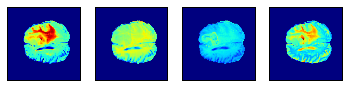

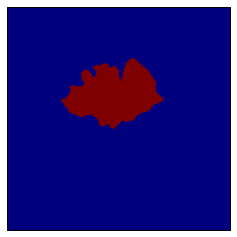

 * Input: size of image: 240 240 4
  [TL] InputLayer  u_net/inputs: (15, 240, 240, 4)
  [TL] Conv2dLayer u_net/conv1: shape:[4, 4, 4, 64] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] Conv2dLayer u_net/conv2: shape:[4, 4, 64, 128] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn2: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv3: shape:[4, 4, 128, 256] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn3: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv4: shape:[4, 4, 256, 512] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn4: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv5: shape:[4, 4, 512, 512] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn5: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv6: shape:[4, 4, 512, 512] strid

  [*] geting variables with u_net
  got   0: u_net/conv1/W_conv2d:0   (4, 4, 4, 64)
  got   1: u_net/conv1/b_conv2d:0   (64,)
  got   2: u_net/conv2/W_conv2d:0   (4, 4, 64, 128)
  got   3: u_net/conv2/b_conv2d:0   (128,)
  got   4: u_net/bn2/beta:0   (128,)
  got   5: u_net/bn2/gamma:0   (128,)
  got   6: u_net/conv3/W_conv2d:0   (4, 4, 128, 256)
  got   7: u_net/conv3/b_conv2d:0   (256,)
  got   8: u_net/bn3/beta:0   (256,)
  got   9: u_net/bn3/gamma:0   (256,)
  got  10: u_net/conv4/W_conv2d:0   (4, 4, 256, 512)
  got  11: u_net/conv4/b_conv2d:0   (512,)
  got  12: u_net/bn4/beta:0   (512,)
  got  13: u_net/bn4/gamma:0   (512,)
  got  14: u_net/conv5/W_conv2d:0   (4, 4, 512, 512)
  got  15: u_net/conv5/b_conv2d:0   (512,)
  got  16: u_net/bn5/beta:0   (512,)
  got  17: u_net/bn5/gamma:0   (512,)
  got  18: u_net/conv6/W_conv2d:0   (4, 4, 512, 512)
  got  19: u_net/conv6/b_conv2d:0   (512,)
  got  20: u_net/bn6/beta:0   (512,)
  got  21: u_net/bn6/gamma:0   (512,)
  got  22: u_net/con

 ** Epoch [9/25] train 1-dice: 0.121028 hard-dice: 0.840460 iou: 0.729604 took 1154.296533s (2d with distortion)
 **                 test 1-dice: 0.138886 hard-dice: 0.835291 iou: 0.723635 (2d no distortion)
 task: all
[*] checkpoint/u_net_all.npz saved
Epoch 10 step 100 1-dice: 0.130706 hard-dice: 0.809716 iou: 0.680271 took 3.430222s (2d with distortion)
Epoch 10 step 200 1-dice: 0.081758 hard-dice: 0.877610 iou: 0.781912 took 3.401697s (2d with distortion)
Epoch 10 step 300 1-dice: 0.116358 hard-dice: 0.845578 iou: 0.732469 took 3.427419s (2d with distortion)
 ** Epoch [10/25] train 1-dice: 0.126496 hard-dice: 0.832415 iou: 0.719666 took 1154.096751s (2d with distortion)
 **                 test 1-dice: 0.126620 hard-dice: 0.849854 iou: 0.744596 (2d no distortion)
 task: all
[*] checkpoint/u_net_all.npz saved
Epoch 11 step 100 1-dice: 0.390400 hard-dice: 0.492234 iou: 0.326466 took 3.402831s (2d with distortion)
Epoch 11 step 200 1-dice: 0.069081 hard-dice: 0.907518 iou: 0.830694 to

[*] checkpoint/u_net_all.npz saved
Epoch 24 step 100 1-dice: 0.145110 hard-dice: 0.815062 iou: 0.687852 took 3.400622s (2d with distortion)
Epoch 24 step 200 1-dice: 0.075572 hard-dice: 0.886112 iou: 0.795513 took 3.396781s (2d with distortion)
Epoch 24 step 300 1-dice: 0.156473 hard-dice: 0.793191 iou: 0.657263 took 3.403864s (2d with distortion)
 ** Epoch [24/25] train 1-dice: 0.095245 hard-dice: 0.866039 iou: 0.768926 took 1153.097021s (2d with distortion)
 **                 test 1-dice: 0.105071 hard-dice: 0.869636 iou: 0.772168 (2d no distortion)
 task: all
[*] checkpoint/u_net_all.npz saved
Epoch 25 step 100 1-dice: 0.058790 hard-dice: 0.907660 iou: 0.830931 took 3.427596s (2d with distortion)
Epoch 25 step 200 1-dice: 0.113655 hard-dice: 0.829920 iou: 0.709285 took 3.401028s (2d with distortion)
Epoch 25 step 300 1-dice: 0.093626 hard-dice: 0.873426 iou: 0.775294 took 3.410700s (2d with distortion)
 ** Epoch [25/25] train 1-dice: 0.092241 hard-dice: 0.869919 iou: 0.775497 took 

In [6]:
#0 get_mixed_datasets, batch size 15, 25 epochs 
run_u_net()

[!] checkpoint exists ...
Enter t: 1
('X_train:', (5084, 240, 240, 4))
('X_test:', (3410, 240, 240, 4))
('y_train:', (5084, 240, 240))
('y_test:', (3410, 240, 240))
(240, 240, 4) -0.338576 3.7946339
(240, 240, 1) 0 1


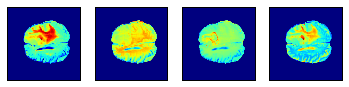

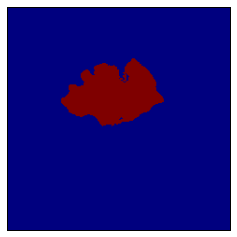

 * Input: size of image: 240 240 4
  [TL] InputLayer  u_net/inputs: (15, 240, 240, 4)
  [TL] Conv2dLayer u_net/conv1: shape:[4, 4, 4, 64] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] Conv2dLayer u_net/conv2: shape:[4, 4, 64, 128] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn2: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv3: shape:[4, 4, 128, 256] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn3: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv4: shape:[4, 4, 256, 512] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn4: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv5: shape:[4, 4, 512, 512] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn5: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv6: shape:[4, 4, 512, 512] strid

  [*] geting variables with u_net
  got   0: u_net/conv1/W_conv2d:0   (4, 4, 4, 64)
  got   1: u_net/conv1/b_conv2d:0   (64,)
  got   2: u_net/conv2/W_conv2d:0   (4, 4, 64, 128)
  got   3: u_net/conv2/b_conv2d:0   (128,)
  got   4: u_net/bn2/beta:0   (128,)
  got   5: u_net/bn2/gamma:0   (128,)
  got   6: u_net/conv3/W_conv2d:0   (4, 4, 128, 256)
  got   7: u_net/conv3/b_conv2d:0   (256,)
  got   8: u_net/bn3/beta:0   (256,)
  got   9: u_net/bn3/gamma:0   (256,)
  got  10: u_net/conv4/W_conv2d:0   (4, 4, 256, 512)
  got  11: u_net/conv4/b_conv2d:0   (512,)
  got  12: u_net/bn4/beta:0   (512,)
  got  13: u_net/bn4/gamma:0   (512,)
  got  14: u_net/conv5/W_conv2d:0   (4, 4, 512, 512)
  got  15: u_net/conv5/b_conv2d:0   (512,)
  got  16: u_net/bn5/beta:0   (512,)
  got  17: u_net/bn5/gamma:0   (512,)
  got  18: u_net/conv6/W_conv2d:0   (4, 4, 512, 512)
  got  19: u_net/conv6/b_conv2d:0   (512,)
  got  20: u_net/bn6/beta:0   (512,)
  got  21: u_net/bn6/gamma:0   (512,)
  got  22: u_net/con

 ** Epoch [9/25] train 1-dice: 0.080873 hard-dice: 0.883146 iou: 0.793876 took 1135.676760s (2d with distortion)
 **                 test 1-dice: 0.093518 hard-dice: 0.881931 iou: 0.791954 (2d no distortion)
 task: all
[*] checkpoint/u_net_all.npz saved
Epoch 10 step 100 1-dice: 0.051842 hard-dice: 0.923444 iou: 0.857776 took 3.351020s (2d with distortion)
Epoch 10 step 200 1-dice: 0.085716 hard-dice: 0.873397 iou: 0.775248 took 3.338481s (2d with distortion)
Epoch 10 step 300 1-dice: 0.045584 hard-dice: 0.932602 iou: 0.873715 took 3.346841s (2d with distortion)
 ** Epoch [10/25] train 1-dice: 0.081691 hard-dice: 0.882635 iou: 0.793469 took 1135.611920s (2d with distortion)
 **                 test 1-dice: 0.101744 hard-dice: 0.874958 iou: 0.783198 (2d no distortion)
 task: all
[*] checkpoint/u_net_all.npz saved
Epoch 11 step 100 1-dice: 0.220471 hard-dice: 0.696014 iou: 0.533759 took 3.362017s (2d with distortion)
Epoch 11 step 200 1-dice: 0.026376 hard-dice: 0.955204 iou: 0.914250 to

[*] checkpoint/u_net_all.npz saved
Epoch 24 step 100 1-dice: 0.114884 hard-dice: 0.831029 iou: 0.710907 took 3.351308s (2d with distortion)
Epoch 24 step 200 1-dice: 0.080382 hard-dice: 0.890296 iou: 0.802283 took 3.337841s (2d with distortion)
Epoch 24 step 300 1-dice: 0.033626 hard-dice: 0.943457 iou: 0.892965 took 3.370065s (2d with distortion)
 ** Epoch [24/25] train 1-dice: 0.075239 hard-dice: 0.889425 iou: 0.804409 took 1136.589542s (2d with distortion)
 **                 test 1-dice: 0.088626 hard-dice: 0.888092 iou: 0.801926 (2d no distortion)
 task: all
[*] checkpoint/u_net_all.npz saved
Epoch 25 step 100 1-dice: 0.072760 hard-dice: 0.893131 iou: 0.806899 took 3.340285s (2d with distortion)
Epoch 25 step 200 1-dice: 0.081725 hard-dice: 0.883501 iou: 0.791314 took 3.363901s (2d with distortion)
Epoch 25 step 300 1-dice: 0.106027 hard-dice: 0.836883 iou: 0.719518 took 3.335794s (2d with distortion)
 ** Epoch [25/25] train 1-dice: 0.075494 hard-dice: 0.889619 iou: 0.804363 took 

In [6]:
#1 get_mixed_datasets, batch size 15, 25 epochs 
run_u_net()

[!] checkpoint exists ...
Enter t: 2
('X_train:', (5084, 240, 240, 4))
('X_test:', (3410, 240, 240, 4))
('y_train:', (5084, 240, 240))
('y_test:', (3410, 240, 240))
(240, 240, 4) -0.338576 3.7814076
(240, 240, 1) 0 1


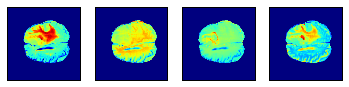

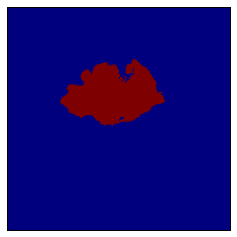

 * Input: size of image: 240 240 4
  [TL] InputLayer  u_net/inputs: (15, 240, 240, 4)
  [TL] Conv2dLayer u_net/conv1: shape:[4, 4, 4, 64] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] Conv2dLayer u_net/conv2: shape:[4, 4, 64, 128] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn2: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv3: shape:[4, 4, 128, 256] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn3: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv4: shape:[4, 4, 256, 512] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn4: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv5: shape:[4, 4, 512, 512] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn5: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv6: shape:[4, 4, 512, 512] strid

  [*] geting variables with u_net
  got   0: u_net/conv1/W_conv2d:0   (4, 4, 4, 64)
  got   1: u_net/conv1/b_conv2d:0   (64,)
  got   2: u_net/conv2/W_conv2d:0   (4, 4, 64, 128)
  got   3: u_net/conv2/b_conv2d:0   (128,)
  got   4: u_net/bn2/beta:0   (128,)
  got   5: u_net/bn2/gamma:0   (128,)
  got   6: u_net/conv3/W_conv2d:0   (4, 4, 128, 256)
  got   7: u_net/conv3/b_conv2d:0   (256,)
  got   8: u_net/bn3/beta:0   (256,)
  got   9: u_net/bn3/gamma:0   (256,)
  got  10: u_net/conv4/W_conv2d:0   (4, 4, 256, 512)
  got  11: u_net/conv4/b_conv2d:0   (512,)
  got  12: u_net/bn4/beta:0   (512,)
  got  13: u_net/bn4/gamma:0   (512,)
  got  14: u_net/conv5/W_conv2d:0   (4, 4, 512, 512)
  got  15: u_net/conv5/b_conv2d:0   (512,)
  got  16: u_net/bn5/beta:0   (512,)
  got  17: u_net/bn5/gamma:0   (512,)
  got  18: u_net/conv6/W_conv2d:0   (4, 4, 512, 512)
  got  19: u_net/conv6/b_conv2d:0   (512,)
  got  20: u_net/bn6/beta:0   (512,)
  got  21: u_net/bn6/gamma:0   (512,)
  got  22: u_net/con

 ** Epoch [9/25] train 1-dice: 0.070377 hard-dice: 0.895086 iou: 0.812736 took 1137.376616s (2d with distortion)
 **                 test 1-dice: 0.085151 hard-dice: 0.892226 iou: 0.807637 (2d no distortion)
 task: all
[*] checkpoint/u_net_all.npz saved
Epoch 10 step 100 1-dice: 0.102629 hard-dice: 0.849308 iou: 0.738084 took 3.404236s (2d with distortion)
Epoch 10 step 200 1-dice: 0.065329 hard-dice: 0.899126 iou: 0.816738 took 3.418748s (2d with distortion)
Epoch 10 step 300 1-dice: 0.044700 hard-dice: 0.928490 iou: 0.866524 took 3.352437s (2d with distortion)
 ** Epoch [10/25] train 1-dice: 0.070422 hard-dice: 0.894946 iou: 0.812251 took 1137.740463s (2d with distortion)
 **                 test 1-dice: 0.092265 hard-dice: 0.883983 iou: 0.795382 (2d no distortion)
 task: all
[*] checkpoint/u_net_all.npz saved
Epoch 11 step 100 1-dice: 0.112824 hard-dice: 0.842577 iou: 0.727976 took 3.361995s (2d with distortion)
Epoch 11 step 200 1-dice: 0.074157 hard-dice: 0.893515 iou: 0.807525 to

[*] checkpoint/u_net_all.npz saved
Epoch 24 step 100 1-dice: 0.071269 hard-dice: 0.892668 iou: 0.806143 took 3.347672s (2d with distortion)
Epoch 24 step 200 1-dice: 0.129877 hard-dice: 0.822178 iou: 0.698049 took 3.376049s (2d with distortion)
Epoch 24 step 300 1-dice: 0.055371 hard-dice: 0.913096 iou: 0.840089 took 3.373292s (2d with distortion)
 ** Epoch [24/25] train 1-dice: 0.068336 hard-dice: 0.897397 iou: 0.817705 took 1136.786794s (2d with distortion)
 **                 test 1-dice: 0.083238 hard-dice: 0.894896 iou: 0.813156 (2d no distortion)
 task: all
[*] checkpoint/u_net_all.npz saved
Epoch 25 step 100 1-dice: 0.059261 hard-dice: 0.905543 iou: 0.827390 took 3.344225s (2d with distortion)
Epoch 25 step 200 1-dice: 0.054431 hard-dice: 0.917197 iou: 0.847059 took 3.342519s (2d with distortion)
Epoch 25 step 300 1-dice: 0.038189 hard-dice: 0.940256 iou: 0.887248 took 3.367671s (2d with distortion)
 ** Epoch [25/25] train 1-dice: 0.065268 hard-dice: 0.901764 iou: 0.823311 took 

In [6]:
#2 get_mixed_datasets, batch size 15, 25 epochs 
run_u_net()

[!] checkpoint exists ...
Enter t: 3
('X_train:', (5084, 240, 240, 4))
('X_test:', (3410, 240, 240, 4))
('y_train:', (5084, 240, 240))
('y_test:', (3410, 240, 240))
(240, 240, 4) -0.338576 3.7747946
(240, 240, 1) 0 1


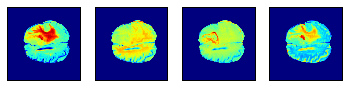

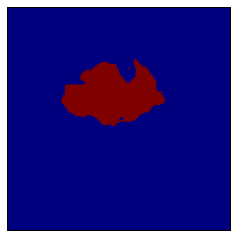

 * Input: size of image: 240 240 4
  [TL] InputLayer  u_net/inputs: (15, 240, 240, 4)
  [TL] Conv2dLayer u_net/conv1: shape:[4, 4, 4, 64] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] Conv2dLayer u_net/conv2: shape:[4, 4, 64, 128] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn2: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv3: shape:[4, 4, 128, 256] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn3: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv4: shape:[4, 4, 256, 512] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn4: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv5: shape:[4, 4, 512, 512] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn5: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv6: shape:[4, 4, 512, 512] strid

  [*] geting variables with u_net
  got   0: u_net/conv1/W_conv2d:0   (4, 4, 4, 64)
  got   1: u_net/conv1/b_conv2d:0   (64,)
  got   2: u_net/conv2/W_conv2d:0   (4, 4, 64, 128)
  got   3: u_net/conv2/b_conv2d:0   (128,)
  got   4: u_net/bn2/beta:0   (128,)
  got   5: u_net/bn2/gamma:0   (128,)
  got   6: u_net/conv3/W_conv2d:0   (4, 4, 128, 256)
  got   7: u_net/conv3/b_conv2d:0   (256,)
  got   8: u_net/bn3/beta:0   (256,)
  got   9: u_net/bn3/gamma:0   (256,)
  got  10: u_net/conv4/W_conv2d:0   (4, 4, 256, 512)
  got  11: u_net/conv4/b_conv2d:0   (512,)
  got  12: u_net/bn4/beta:0   (512,)
  got  13: u_net/bn4/gamma:0   (512,)
  got  14: u_net/conv5/W_conv2d:0   (4, 4, 512, 512)
  got  15: u_net/conv5/b_conv2d:0   (512,)
  got  16: u_net/bn5/beta:0   (512,)
  got  17: u_net/bn5/gamma:0   (512,)
  got  18: u_net/conv6/W_conv2d:0   (4, 4, 512, 512)
  got  19: u_net/conv6/b_conv2d:0   (512,)
  got  20: u_net/bn6/beta:0   (512,)
  got  21: u_net/bn6/gamma:0   (512,)
  got  22: u_net/con

 ** Epoch [9/25] train 1-dice: 0.068026 hard-dice: 0.897501 iou: 0.817463 took 1137.640273s (2d with distortion)
 **                 test 1-dice: 0.089949 hard-dice: 0.886040 iou: 0.799016 (2d no distortion)
 task: all
[*] checkpoint/u_net_all.npz saved
Epoch 10 step 100 1-dice: 0.050660 hard-dice: 0.924609 iou: 0.859789 took 3.377850s (2d with distortion)
Epoch 10 step 200 1-dice: 0.041547 hard-dice: 0.937425 iou: 0.882221 took 3.350156s (2d with distortion)
Epoch 10 step 300 1-dice: 0.056489 hard-dice: 0.909846 iou: 0.834603 took 3.352167s (2d with distortion)
 ** Epoch [10/25] train 1-dice: 0.064084 hard-dice: 0.902832 iou: 0.825005 took 1137.918689s (2d with distortion)
 **                 test 1-dice: 0.087234 hard-dice: 0.888638 iou: 0.802408 (2d no distortion)
 task: all
[*] checkpoint/u_net_all.npz saved
Epoch 11 step 100 1-dice: 0.058722 hard-dice: 0.912120 iou: 0.838438 took 3.371966s (2d with distortion)
Epoch 11 step 200 1-dice: 0.053983 hard-dice: 0.914730 iou: 0.842860 to

[*] checkpoint/u_net_all.npz saved
Epoch 24 step 100 1-dice: 0.038270 hard-dice: 0.939510 iou: 0.885920 took 3.349824s (2d with distortion)
Epoch 24 step 200 1-dice: 0.109071 hard-dice: 0.839221 iou: 0.722981 took 3.552616s (2d with distortion)
Epoch 24 step 300 1-dice: 0.039547 hard-dice: 0.936818 iou: 0.881145 took 3.367969s (2d with distortion)
 ** Epoch [24/25] train 1-dice: 0.061844 hard-dice: 0.905901 iou: 0.830653 took 1137.698264s (2d with distortion)
 **                 test 1-dice: 0.084927 hard-dice: 0.893075 iou: 0.809587 (2d no distortion)
 task: all
[*] checkpoint/u_net_all.npz saved
Epoch 25 step 100 1-dice: 0.040156 hard-dice: 0.939413 iou: 0.885748 took 3.358930s (2d with distortion)
Epoch 25 step 200 1-dice: 0.301102 hard-dice: 0.630664 iou: 0.460562 took 3.329320s (2d with distortion)
Epoch 25 step 300 1-dice: 0.035518 hard-dice: 0.940960 iou: 0.888502 took 3.382624s (2d with distortion)
 ** Epoch [25/25] train 1-dice: 0.060639 hard-dice: 0.907073 iou: 0.832704 took 

In [6]:
#3 get_mixed_datasets, batch size 15, 25 epochs 
run_u_net()

[!] checkpoint exists ...
Enter t: 4
('X_train:', (5084, 240, 240, 4))
('X_test:', (3410, 240, 240, 4))
('y_train:', (5084, 240, 240))
('y_test:', (3410, 240, 240))
(240, 240, 4) -0.338576 3.7747946
(240, 240, 1) 0 1


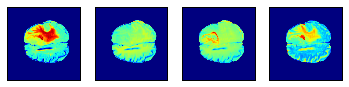

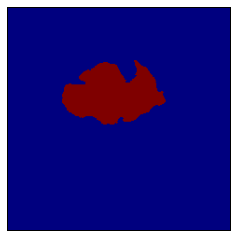

 * Input: size of image: 240 240 4
  [TL] InputLayer  u_net/inputs: (15, 240, 240, 4)
  [TL] Conv2dLayer u_net/conv1: shape:[4, 4, 4, 64] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] Conv2dLayer u_net/conv2: shape:[4, 4, 64, 128] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn2: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv3: shape:[4, 4, 128, 256] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn3: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv4: shape:[4, 4, 256, 512] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn4: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv5: shape:[4, 4, 512, 512] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer u_net/bn5: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:True
  [TL] Conv2dLayer u_net/conv6: shape:[4, 4, 512, 512] strid

  [*] geting variables with u_net
  got   0: u_net/conv1/W_conv2d:0   (4, 4, 4, 64)
  got   1: u_net/conv1/b_conv2d:0   (64,)
  got   2: u_net/conv2/W_conv2d:0   (4, 4, 64, 128)
  got   3: u_net/conv2/b_conv2d:0   (128,)
  got   4: u_net/bn2/beta:0   (128,)
  got   5: u_net/bn2/gamma:0   (128,)
  got   6: u_net/conv3/W_conv2d:0   (4, 4, 128, 256)
  got   7: u_net/conv3/b_conv2d:0   (256,)
  got   8: u_net/bn3/beta:0   (256,)
  got   9: u_net/bn3/gamma:0   (256,)
  got  10: u_net/conv4/W_conv2d:0   (4, 4, 256, 512)
  got  11: u_net/conv4/b_conv2d:0   (512,)
  got  12: u_net/bn4/beta:0   (512,)
  got  13: u_net/bn4/gamma:0   (512,)
  got  14: u_net/conv5/W_conv2d:0   (4, 4, 512, 512)
  got  15: u_net/conv5/b_conv2d:0   (512,)
  got  16: u_net/bn5/beta:0   (512,)
  got  17: u_net/bn5/gamma:0   (512,)
  got  18: u_net/conv6/W_conv2d:0   (4, 4, 512, 512)
  got  19: u_net/conv6/b_conv2d:0   (512,)
  got  20: u_net/bn6/beta:0   (512,)
  got  21: u_net/bn6/gamma:0   (512,)
  got  22: u_net/con

 ** Epoch [9/25] train 1-dice: 0.058108 hard-dice: 0.910215 iou: 0.836858 took 1139.240385s (2d with distortion)
 **                 test 1-dice: 0.081504 hard-dice: 0.896230 iou: 0.813978 (2d no distortion)
 task: all
[*] checkpoint/u_net_all.npz saved
Epoch 10 step 100 1-dice: 0.048070 hard-dice: 0.918240 iou: 0.848838 took 3.364603s (2d with distortion)
Epoch 10 step 200 1-dice: 0.058580 hard-dice: 0.911952 iou: 0.838155 took 3.356415s (2d with distortion)
Epoch 10 step 300 1-dice: 0.066269 hard-dice: 0.895830 iou: 0.811315 took 3.382623s (2d with distortion)
 ** Epoch [10/25] train 1-dice: 0.058239 hard-dice: 0.910128 iou: 0.837133 took 1139.414250s (2d with distortion)
 **                 test 1-dice: 0.080935 hard-dice: 0.896859 iou: 0.815498 (2d no distortion)
 task: all
[*] checkpoint/u_net_all.npz saved
Epoch 11 step 100 1-dice: 0.081248 hard-dice: 0.872528 iou: 0.773881 took 3.356632s (2d with distortion)
Epoch 11 step 200 1-dice: 0.076549 hard-dice: 0.876229 iou: 0.779722 to

[*] checkpoint/u_net_all.npz saved
Epoch 24 step 100 1-dice: 0.038359 hard-dice: 0.936659 iou: 0.880865 took 3.372879s (2d with distortion)
Epoch 24 step 200 1-dice: 0.059986 hard-dice: 0.907098 iou: 0.829990 took 3.346192s (2d with distortion)
Epoch 24 step 300 1-dice: 0.069443 hard-dice: 0.890114 iou: 0.801988 took 3.376567s (2d with distortion)
 ** Epoch [24/25] train 1-dice: 0.055262 hard-dice: 0.913578 iou: 0.842313 took 1141.374073s (2d with distortion)
 **                 test 1-dice: 0.080215 hard-dice: 0.898275 iou: 0.817948 (2d no distortion)
 task: all
[*] checkpoint/u_net_all.npz saved
Epoch 25 step 100 1-dice: 0.068826 hard-dice: 0.896166 iou: 0.811867 took 3.343087s (2d with distortion)
Epoch 25 step 200 1-dice: 0.096803 hard-dice: 0.852256 iou: 0.742548 took 3.382521s (2d with distortion)
Epoch 25 step 300 1-dice: 0.191684 hard-dice: 0.733414 iou: 0.579048 took 3.354800s (2d with distortion)
 ** Epoch [25/25] train 1-dice: 0.060974 hard-dice: 0.905944 iou: 0.831065 took 

In [6]:
#4 get_mixed_datasets, batch size 15, 25 epochs 
run_u_net()